In [34]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime as dt

In [2]:
histObs = pd.read_csv('https://raw.githubusercontent.com/Tanag3r/trailheadDirect_birds/main/cooking/EastSunsetWay_Obs_2019to2021.csv')
histObs.head()

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,dowwoo,Downy Woodpecker,Dryobates pubescens,L10128988,Berntsen Park,2019-11-06 09:45,1.0,47.538439,-122.043281,True,False,False,S61278505
1,norfli,Northern Flicker,Colaptes auratus,L10128988,Berntsen Park,2019-11-06 09:45,1.0,47.538439,-122.043281,True,False,False,S61278505
2,amecro,American Crow,Corvus brachyrhynchos,L10128988,Berntsen Park,2019-11-06 09:45,2.0,47.538439,-122.043281,True,False,False,S61278505
3,bkcchi,Black-capped Chickadee,Poecile atricapillus,L10128988,Berntsen Park,2019-11-06 09:45,3.0,47.538439,-122.043281,True,False,False,S61278505
4,ruckin,Ruby-crowned Kinglet,Corthylio calendula,L10128988,Berntsen Park,2019-11-06 09:45,1.0,47.538439,-122.043281,True,False,False,S61278505


In [61]:
##cleanup
histObs['obsDt'] = histObs['obsDt'].astype('datetime64[ns]')
histObs['howMany'] = histObs['howMany'].fillna(1)
histObs['howMany'] = histObs['howMany'].astype('int32')
##add month,year and week of year
histObs['obsDt_year'] = pd.DatetimeIndex(histObs['obsDt']).year
histObs['obsDt_month'] = pd.DatetimeIndex(histObs['obsDt']).month
histObs['obsDt_week'] = histObs['obsDt'].dt.isocalendar().week

histObs.dtypes

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId,obsDt_year,obsDt_month,obsDt_week
0,dowwoo,Downy Woodpecker,Dryobates pubescens,L10128988,Berntsen Park,2019-11-06 09:45:00,1,47.538439,-122.043281,True,False,False,S61278505,2019,11,45
1,norfli,Northern Flicker,Colaptes auratus,L10128988,Berntsen Park,2019-11-06 09:45:00,1,47.538439,-122.043281,True,False,False,S61278505,2019,11,45
2,amecro,American Crow,Corvus brachyrhynchos,L10128988,Berntsen Park,2019-11-06 09:45:00,2,47.538439,-122.043281,True,False,False,S61278505,2019,11,45
3,bkcchi,Black-capped Chickadee,Poecile atricapillus,L10128988,Berntsen Park,2019-11-06 09:45:00,3,47.538439,-122.043281,True,False,False,S61278505,2019,11,45
4,ruckin,Ruby-crowned Kinglet,Corthylio calendula,L10128988,Berntsen Park,2019-11-06 09:45:00,1,47.538439,-122.043281,True,False,False,S61278505,2019,11,45


Build relative diversity map for each trailhead. Map is similar to Github's contribution map

In [71]:
##frame of unique species seen each month
histObs_diversity = histObs.sort_values(by=['obsDt_year','obsDt_month','obsDt_week'],ascending=True)
histObs_diversity.drop_duplicates(subset=['obsDt_year','obsDt_month','obsDt_week','comName'],keep='first')

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId,obsDt_year,obsDt_month,obsDt_week
62,mallar3,Mallard,Anas platyrhynchos,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,2,47.529503,-122.039512,True,False,False,S51278518,2019,1,1
63,annhum,Anna's Hummingbird,Calypte anna,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,2,47.529503,-122.039512,True,False,False,S51278518,2019,1,1
64,bkcchi,Black-capped Chickadee,Poecile atricapillus,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,1,47.529503,-122.039512,True,False,False,S51278518,2019,1,1
65,chbchi,Chestnut-backed Chickadee,Poecile rufescens,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,1,47.529503,-122.039512,True,False,False,S51278518,2019,1,1
66,daejun,Dark-eyed Junco,Junco hyemalis,L8102503,Issaquah Salmon Hatchery,2019-01-03 15:26:00,24,47.529503,-122.039512,True,False,False,S51278518,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,gockin,Golden-crowned Kinglet,Regulus satrapa,L424117,Tradition Plateau,2020-12-25 12:48:00,45,47.529496,-121.996205,True,False,False,S77975587,2020,12,52
792,rebnut,Red-breasted Nuthatch,Sitta canadensis,L424117,Tradition Plateau,2020-12-25 12:48:00,4,47.529496,-121.996205,True,False,False,S77975587,2020,12,52
793,brncre,Brown Creeper,Certhia americana,L424117,Tradition Plateau,2020-12-25 12:48:00,1,47.529496,-121.996205,True,False,False,S77975587,2020,12,52
797,spotow,Spotted Towhee,Pipilo maculatus,L424117,Tradition Plateau,2020-12-25 12:48:00,1,47.529496,-121.996205,True,False,False,S77975587,2020,12,52


In [72]:
histObs_obsv = histObs.groupby(['obsDt_year','obsDt_month','obsDt_week'])['subId'].count()
histObs_obsv = pd.DataFrame(histObs_obsv)
histObs_birdCount = histObs.groupby(['obsDt_year','obsDt_month','obsDt_week','comName'])['howMany'].sum()
histObs_birdCount = pd.DataFrame(histObs_birdCount)
histObs_diversity = histObs_diversity.groupby(['obsDt_year','obsDt_month','obsDt_week'])['comName'].count()
histObs_diversity = pd.DataFrame(histObs_diversity)

In [73]:
histObs_obsv.index.set_names(["year","month","week"], inplace=True)
histObs_birdCount.index.set_names(["year","month","week","comName"], inplace=True)
histObs_diversity.index.set_names(["year","month","week"], inplace=True)

In [74]:
histObs_birdCount = histObs_birdCount.reset_index()
histObs_obsv = histObs_obsv.reset_index()
histObs_diversity = histObs_diversity.reset_index()

In [91]:
##combine date values for plotting as YYYY-MM-WW
histObs_diversity['obsPeriod'] = histObs_diversity[['year','month','week']].astype(str).agg('-'.join,axis=1)

histObs_diversity.head()

,year,month,week,comName,obsPeriod
0,2019,1,1,7,2019-1-1
1,2019,1,3,13,2019-1-3
2,2019,2,5,5,2019-2-5
3,2019,2,6,7,2019-2-6
4,2019,3,12,12,2019-3-12


In [ ]:
##todo #11 layer annual historical for trailheads by year, month

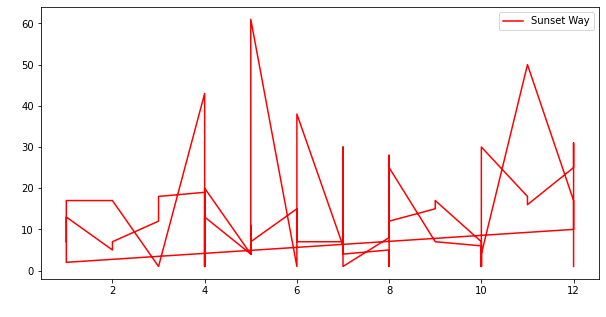

In [92]:
##fix
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Date',color='w')
plt.ylabel('# of Species',color='w')
plt.plot(histObs_diversity.month,histObs_diversity.comName,color='r',label='Sunset Way')
##plt.axis(histObs_diversity['month'],color='w')
ax.set_yscale('linear')
plt.legend()
plt.show()